In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv3D,
    BatchNormalization,
    ELU,
    add,
    MaxPooling3D,
    Flatten,
    Dense,
    Dropout,
    concatenate,
    UpSampling3D,
    Reshape,
    Conv3DTranspose,
)
from tensorflow.keras.regularizers import l2 as L2

def ResidualBlock(x, features, paddingType='same', initType='he_uniform', regAmount=0.00005):
    shortcut = Conv3D(features, (1, 1, 1), strides=(1, 1, 1), padding=paddingType, kernel_initializer=initType, kernel_regularizer=L2(regAmount))(x)
    x = Conv3D(features, (3, 3, 3), padding=paddingType, kernel_initializer=initType, kernel_regularizer=L2(regAmount))(x)
    x = BatchNormalization()(x)
    x = ELU(alpha=1.0)(x)
    x = Conv3D(features, (3, 3, 3), padding=paddingType, kernel_initializer=initType, kernel_regularizer=L2(regAmount))(x)
    x = BatchNormalization()(x)
    x = add([shortcut, x])
    x = ELU(alpha=1.0)(x)
    return x

def EncoderWithSelectiveDeepSupervision(input_shape, features_list, paddingType='same', initType='he_uniform', regAmount=0.00005):
    inputs = Input(shape=input_shape + (1,), name='Input')
    x = inputs

    # Lists to hold auxiliary outputs for specific blocks
    age_outputs = []
    gender_outputs = []

    for i, features in enumerate(features_list):
        x = ResidualBlock(x, features, paddingType, initType, regAmount)

        # Add auxiliary outputs only after the 2nd and 4th residual blocks
        if i in {1, 3}:  # Zero-based index, so 2nd block is 1 and 4th block is 3
            flat = Flatten()(x)
            dense = Dense(128, activation='relu')(flat)
            
            age_output = Dense(1, kernel_initializer=initType, kernel_regularizer=L2(regAmount), name=f'AgeOutput_Block{i+1}')(dense)
            gender_output = Dense(1, activation='sigmoid', kernel_initializer=initType, kernel_regularizer=L2(regAmount), name=f'GenderOutput_Block{i+1}')(dense)
            
            age_outputs.append(age_output)
            gender_outputs.append(gender_output)

        x = MaxPooling3D(pool_size=(2, 2, 2), padding=paddingType)(x)

    encoded = x
    return Model(inputs, [encoded] + age_outputs + gender_outputs, name='EncoderWithSelectiveDeepSupervision')

def Decoder(encoded_shape, output_shape, features_list, paddingType='same', initType='he_uniform', regAmount=0.00005):
    inputs = Input(shape=encoded_shape[1:], name='EncodedInput')
    x = inputs
    for features in reversed(features_list):
        x = UpSampling3D(size=(2, 2, 2))(x)
        x = ResidualBlock(x, features, paddingType, initType, regAmount)
    x = Conv3D(output_shape[-1], (3, 3, 3), activation='sigmoid', padding=paddingType, kernel_initializer=initType)(x)
    x = Reshape(output_shape)(x)
    return Model(inputs, x, name='Decoder')

def MultiTaskAutoencoderWithSelectiveDeepSupervision(input_shape, features_list, paddingType='same', initType='he_uniform', regAmount=0.00005):
    encoder = EncoderWithSelectiveDeepSupervision(input_shape, features_list, paddingType, initType, regAmount)
    encoded_shape = encoder.output_shape[0]

    decoder = Decoder(encoded_shape, input_shape + (1,), features_list, paddingType, initType, regAmount)
    
    # Main branches for age and gender
    flat = Flatten()(encoder.outputs[0])
    dense = Dense(128, activation='relu')(flat)
    
    age_prediction = Dense(1, kernel_initializer=initType, kernel_regularizer=L2(regAmount), name='AgePrediction')(dense)
    gender_prediction = Dense(1, activation='sigmoid', kernel_initializer=initType, kernel_regularizer=L2(regAmount), name='GenderPrediction')(dense)
    
    inputs = encoder.input
    reconstruction = decoder(encoder.outputs[0])
    
    # Collect all outputs: reconstruction, main, and selective auxiliary
    model_outputs = [reconstruction, age_prediction, gender_prediction] + encoder.outputs[1:]
    
    model = Model(inputs, model_outputs, name='MultiTaskAutoencoderWithSelectiveDeepSupervision')
    return model

# Define the input shape and features list
input_shape = (96, 96, 96)
features_list = [8, 16, 32, 64, 128]

# Create the model with selective deep supervision
autoencoder_with_selective_supervision_model = MultiTaskAutoencoderWithSelectiveDeepSupervision(input_shape, features_list)

# Display the model summary
autoencoder_with_selective_supervision_model.summary()


Model: "MultiTaskAutoencoderWithSelectiveDeepSupervision"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 96, 96, 96,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d_1 (Conv3D)              (None, 96, 96, 96,   224         ['Input[0][0]']                  
                                8)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 96, 96, 96,   32         ['conv3d_1[0][0]']               
 alization)                     8)                 

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import os
import numpy as np
from scipy.ndimage import zoom, rotate
import random
from tensorflow.keras.models import load_model
import wandb
from wandb.integration.keras import WandbCallback

# Initialize W&B
wandb.init(
    project='selectively_deep_supervision_MTAE_for_brain_age',  # Set your project name
    config={
        "epochs": 100,
        "batch_size": 8,
        "learning_rate": 0.001,
        "architecture": "multi-task-autoencoder"
    }
)

# Define a function for cosine decay learning rate schedule
def cosine_decay_schedule(initial_lr, epoch, total_epochs):
    lr = 0.5 * initial_lr * (1 + np.cos(np.pi * epoch / total_epochs))
    return lr


class DataGenerator(Sequence):
    def __init__(self, data_dir, participants, batch_size=8, dim=(96, 96, 96), shuffle=True, augment=False):
        self.data_dir = data_dir
        self.participants = participants
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = np.arange(len(self.participants))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.participants) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        participants_temp = [self.participants.iloc[k] for k in indexes]
        X, y_age, y_gender = self.__data_generation(participants_temp)
        
        # Prepare the outputs for selective deep supervision
        outputs = {
            'Decoder': X,
            'AgePrediction': y_age,
            'GenderPrediction': y_gender,
            'AgeOutput_Block2': y_age,
            'GenderOutput_Block2': y_gender,
            'AgeOutput_Block4': y_age,
            'GenderOutput_Block4': y_gender
        }
        
        return {'Input': X}, outputs
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, participants_temp):
        X = np.empty((self.batch_size, *self.dim, 1))
        y_age = np.empty((self.batch_size,))
        y_gender = np.empty((self.batch_size,))

        for i, participant in enumerate(participants_temp):
            file_path = os.path.join(self.data_dir, f'sub-{participant["participant_id"]}_preproc-quasiraw_T1w.npy')
            volume = np.squeeze(np.load(file_path))
            x = get_cropped_volume(volume)
            if self.augment:
                x = self.__augment_volume(x)
            X[i,] = x[..., np.newaxis]
            y_age[i] = participant["age"]
            y_gender[i] = 1 if participant["sex"] == "male" else 0
        
        return X, y_age, y_gender
    
    def __augment_volume(self, volume):
        if random.random() > 0.5:
            volume = np.flip(volume, axis=0)  # Flip along x-axis
        if random.random() > 0.5:
            volume = np.flip(volume, axis=1)  # Flip along y-axis
        if random.random() > 0.5:
            volume = np.flip(volume, axis=2)  # Flip along z-axis
        if random.random() > 0.5:
            volume = rotate(volume, angle=random.uniform(-20, 20), axes=(0, 1), reshape=False)
        if random.random() > 0.5:
            volume = zoom(volume, zoom=random.uniform(0.9, 1.1))
        if random.random() > 0.5:
            volume = self.__random_erasing(volume)
        
        # Resize back to the original dimensions
        volume = zoom(volume, np.array(self.dim) / np.array(volume.shape), order=1)
        return volume

    def __random_erasing(self, volume, p=0.5, s=(0.02, 0.4), r=(0.3, 3)):
        if random.random() > p:
            return volume
        area = volume.shape[0] * volume.shape[1] * volume.shape[2]
        target_area = random.uniform(*s) * area
        aspect_ratio = random.uniform(*r)

        h = int(round(np.sqrt(target_area * aspect_ratio)))
        w = int(round(np.sqrt(target_area / aspect_ratio)))
        d = int(round(np.sqrt(target_area / aspect_ratio)))
        
        if h < volume.shape[0] and w < volume.shape[1] and d < volume.shape[2]:
            x1 = random.randint(0, volume.shape[0] - h)
            y1 = random.randint(0, volume.shape[1] - w)
            z1 = random.randint(0, volume.shape[2] - d)
            volume[x1:x1+h, y1:y1+w, z1:z1+d] = 0
        return volume

def get_normalized(vol):
    norm_volume = (vol - vol.min()) / (vol.max() - vol.min())
    return norm_volume

def downsample_volume(volume, target_shape=(96, 96, 96)):
    zoom_factors = np.array(target_shape) / np.array(volume.shape)
    downsampled_volume = zoom(volume, zoom_factors, order=1)
    return downsampled_volume

def get_cropped_volume(val_sample):
    axial_sum = np.max(val_sample, axis=2)
    axial_msk = axial_sum > axial_sum.mean()
    coronal_sum = np.max(val_sample, axis=1)
    coronal_msk = coronal_sum > coronal_sum.mean()
    
    object_indices = np.argwhere(axial_msk)
    min_bounds = object_indices.min(axis=0)
    max_bounds = object_indices.max(axis=0) + 1
    x_min, x_max, y_min, y_max = min_bounds[0], max_bounds[0], min_bounds[1], max_bounds[1]

    object_indices = np.argwhere(coronal_msk)
    min_bounds = object_indices.min(axis=0)
    max_bounds = object_indices.max(axis=0) + 1
    _, _, z_min, z_max = min_bounds[0], max_bounds[0], min_bounds[1], max_bounds[1]
    
    x_min, x_max = get_fix_cords(x_min, x_max, 152)
    y_min, y_max = get_fix_cords(y_min, y_max, 188)
    z_min, z_max = get_fix_cords(z_min, z_max, 144)
    cropped_volume = val_sample[x_min:x_max, y_min:y_max, z_min:z_max]
    cropped_volume = downsample_volume(cropped_volume, target_shape=(96, 96, 96))
    normalized_volume = get_normalized(cropped_volume)
    
    return normalized_volume

def get_fix_cords(xmn, xmx, fvalue):
    c_point = xmn + (xmx - xmn) / 2
    nx_min = int(c_point - fvalue / 2)
    nx_max = int(c_point + fvalue / 2)
    return nx_min, nx_max

# Update the paths
train_tsv_path = r'C:\Users\User\Documents\Dataset\Brain Age\train\train_labels\participants.tsv'
train_data_dir = r'C:\Users\User\Documents\Dataset\Brain Age\train\train_quasiraw'

# valid_tsv_path = r'C:\Users\User\Documents\Dataset\Brain Age\val\val_labels\participants.tsv'
# valid_data_dir = r'C:\Users\User\Documents\Dataset\Brain Age\val\val_quasiraw'

# Load participants information
train_participants = pd.read_csv(train_tsv_path, sep='\t')
# valid_participants = pd.read_csv(valid_tsv_path, sep='\t')

# Bin the ages into discrete categories for stratification
bins = [0, 18, 25, 35, 50, 100]  # Define age bins
labels = ['0-18', '19-25', '26-35', '36-50', '50+']  # Labels for the bins
train_participants['age_bin'] = pd.cut(train_participants ['age'], bins=bins, labels=labels, right=False)

# Check the distribution in each bin
print(train_participants['age_bin'].value_counts())

# Split the dataset into training and validation sets (90% train, 10% validation)
train_participants, val_participants = train_test_split(
    train_participants,
    test_size=0.1,
    random_state=42,
    stratify=train_participants['age_bin']  # Stratify by the age bins
)

# Drop the 'age_bin' column after splitting if it's not needed
train_participants = train_participants.drop(columns=['age_bin'])
val_participants = val_participants.drop(columns=['age_bin'])


# Load the model
# model_path = 'MTL_AE_best_weights_selective_v1.h5'
# autoencoder_with_selective_supervision_model = load_model(model_path)

# Create data generators with the updated splits
train_generator = DataGenerator(train_data_dir, train_participants, batch_size=4, dim=(96, 96, 96), shuffle=True, augment=True)
val_generator = DataGenerator(train_data_dir, val_participants, batch_size=2, dim=(96, 96, 96), shuffle=False, augment=False)


# Compile the model with multiple loss functions and weights
autoencoder_with_selective_supervision_model.compile(
    optimizer='adam', 
    loss={
        'Decoder': 'mse', 
        'AgePrediction': 'mse', 
        'GenderPrediction': 'binary_crossentropy',
        'AgeOutput_Block2': 'mse',
        'GenderOutput_Block2': 'binary_crossentropy',
        'AgeOutput_Block4': 'mse',
        'GenderOutput_Block4': 'binary_crossentropy'
    }, 
    loss_weights={
        'Decoder': 0.1, 
        'AgePrediction': 0.75, 
        'GenderPrediction': 0.15,
        'AgeOutput_Block2': 0.05,
        'GenderOutput_Block2': 0.025,
        'AgeOutput_Block4': 0.05,
        'GenderOutput_Block4': 0.025
    },
    metrics={
        'AgePrediction': 'mae', 
        'GenderPrediction': 'accuracy',
        'AgeOutput_Block2': 'mae',
        'GenderOutput_Block2': 'accuracy',
        'AgeOutput_Block4': 'mae',
        'GenderOutput_Block4': 'accuracy'
    }
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_AgePrediction_mae', patience=50, restore_best_weights=True)
checkpoint = ModelCheckpoint('./test_weights/DS_MTL_AE_Best_Net.h5', monitor='val_loss', save_best_only=True, mode='min')
tensorboard = TensorBoard(log_dir='./test_weights/logs_multi_task_autoencoder_selective_v1.0')

# Initial learning rate
initial_learning_rate = 0.001

# Learning rate scheduler
lr_scheduler = LearningRateScheduler(lambda epoch: cosine_decay_schedule(initial_learning_rate, epoch, 100))

# Train the model
history = autoencoder_with_selective_supervision_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stopping, checkpoint, tensorboard, lr_scheduler, WandbCallback()],
)

# Save the trained model
autoencoder_with_selective_supervision_model.save('./test_weights/test_weights/DS_MTL_AE_Net.h5')

# Finish W&B run
wandb.finish()


age_bin
19-25    1632
0-18      634
26-35     517
50+       305
36-50     139
Name: count, dtype: int64


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
309/726 [===========>..................] - ETA: 5:58 - loss: 8196.9229 - Decoder_loss: 0.0174 - AgePrediction_loss: 235.2985 - GenderPrediction_loss: 1.1033 - AgeOutput_Block2_loss: 157717.4375 - AgeOutput_Block4_loss: 2666.8022 - GenderOutput_Block2_loss: 30.0531 - GenderOutput_Block4_loss: 8.6335 - AgePrediction_mae: 10.6362 - GenderPrediction_accuracy: 0.4976 - AgeOutput_Block2_mae: 97.9277 - AgeOutput_Block4_mae: 17.0750 - GenderOutput_Block2_accuracy: 0.5348 - GenderOutput_Block4_accuracy: 0.5154

KeyboardInterrupt: 

1/1 [==============================] - 0s 15ms/step
Overall - MSE: 18.23 (SD: 662.82), MAE: 2.87 (SD: 13.04), RMSE: 4.27 (SD: 13.04), R2: 0.89, MAPE: 0.13
Male - MSE: 18.00 (SD: 572.55), MAE: 2.84 (SD: 11.75), RMSE: 4.24 (SD: 11.75), R2: 0.87, MAPE: 0.14
Female - MSE: 18.51 (SD: 739.68), MAE: 2.90 (SD: 14.32), RMSE: 4.30 (SD: 14.32), R2: 0.90, MAPE: 0.11


ValueError: x must have 2 or fewer dimensions

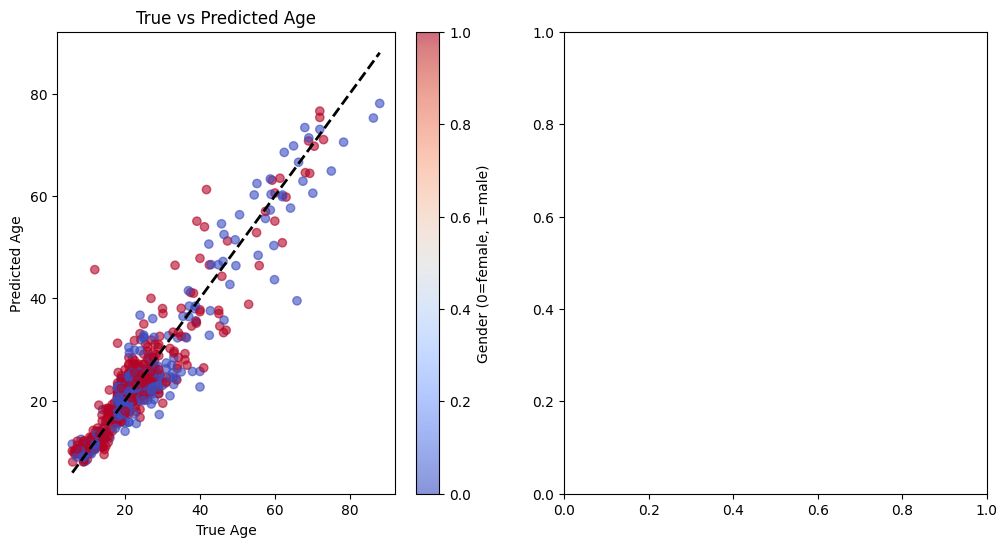

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import load_model

def preprocess_volume(volume):
    x = get_cropped_volume(volume)
    x = x[np.newaxis, ..., np.newaxis]  # Add batch and channel dimensions
    return x

def load_volume(file_path):
    volume = np.squeeze(np.load(file_path))
    return volume

def inference(model, file_path):
    # Load and preprocess the volume
    volume = load_volume(file_path)
    processed_volume = preprocess_volume(volume)
    
    # Get predictions from the model
    # The model now outputs multiple predictions: reconstruction, age, gender, and auxiliary outputs
    predictions = model.predict({'Input': processed_volume})
    
    # Unpack predictions: 
    # 0: Reconstruction, 1: AgePrediction, 2: GenderPrediction, 3: AgeOutput_Block2, 4: GenderOutput_Block2, 
    # 5: AgeOutput_Block4, 6: GenderOutput_Block4
    reconstruction = predictions[0]
    age_prediction = predictions[1][0]
    gender_prediction = predictions[2][0]
    
    # We can optionally access the auxiliary predictions from the 2nd and 4th residual blocks:
    age_aux_block2 = predictions[3][0]
    gender_aux_block2 = predictions[4][0]
    age_aux_block4 = predictions[5][0]
    gender_aux_block4 = predictions[6][0]
    
    # For the primary task, we'll return the main age and gender predictions
    return reconstruction, age_prediction, gender_prediction, age_aux_block2, gender_aux_block2, age_aux_block4, gender_aux_block4

def compute_metrics(true_values, pred_values):
    mse = mean_squared_error(true_values, pred_values)
    mae = mean_absolute_error(true_values, pred_values)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, pred_values)
    mape = mean_absolute_percentage_error(true_values, pred_values)
    return mse, mae, rmse, r2, mape

def compute_sd(values):
    return np.std(values)

# Load the model
model_path = './test_weights/DS_MTL_AE_test_Net.h5'
model = load_model(model_path)

# Load participants information
data_dir = r'C:\Users\User\Documents\Dataset\Brain Age\val\val_quasiraw'
participants_tsv = r'C:\Users\User\Documents\Dataset\Brain Age\val\val_labels\participants.tsv'
participants = pd.read_csv(participants_tsv, sep='\t')

# Initialize lists to store true and predicted values
true_ages = []
pred_ages = []
genders = []
pred_genders = []
aux_ages_block2 = []
aux_genders_block2 = []
aux_ages_block4 = []
aux_genders_block4 = []

# Perform inference on all samples
batch_size = 4
for start_idx in range(0, len(participants), batch_size):
    end_idx = min(start_idx + batch_size, len(participants))
    batch_participants = participants.iloc[start_idx:end_idx]
    
    for index, row in batch_participants.iterrows():
        participant_id = row['participant_id']
        age = row['age']
        gender = row['sex']  # 'male' or 'female'
        file_path = os.path.join(data_dir, f'sub-{participant_id}_preproc-quasiraw_T1w.npy')

        # Perform inference
        reconstruction, age_prediction, gender_prediction, age_aux_block2, gender_aux_block2, age_aux_block4, gender_aux_block4 = inference(model, file_path)

        # Append the true values and predictions
        true_ages.append(age)
        pred_ages.append(age_prediction)
        genders.append(1 if gender == 'male' else 0)
        pred_genders.append(gender_prediction)
        
        # Collect auxiliary outputs for analysis if needed
        aux_ages_block2.append(age_aux_block2)
        aux_genders_block2.append(gender_aux_block2)
        aux_ages_block4.append(age_aux_block4)
        aux_genders_block4.append(gender_aux_block4)

# Convert to numpy arrays
true_ages = np.array(true_ages)
pred_ages = np.array(pred_ages)
genders = np.array(genders)
pred_genders = np.array(pred_genders)
aux_ages_block2 = np.array(aux_ages_block2)
aux_genders_block2 = np.array(aux_genders_block2)
aux_ages_block4 = np.array(aux_ages_block4)
aux_genders_block4 = np.array(aux_genders_block4)

# Compute metrics for overall samples
overall_metrics = compute_metrics(true_ages, pred_ages)
overall_mse_sd = compute_sd((true_ages - pred_ages)**2)
overall_mae_sd = compute_sd(np.abs(true_ages - pred_ages))
overall_rmse_sd = compute_sd(np.sqrt((true_ages - pred_ages)**2))

# Compute metrics for male samples
male_mask = genders == 1
male_metrics = compute_metrics(true_ages[male_mask], pred_ages[male_mask])
male_mse_sd = compute_sd((true_ages[male_mask] - pred_ages[male_mask])**2)
male_mae_sd = compute_sd(np.abs(true_ages[male_mask] - pred_ages[male_mask]))
male_rmse_sd = compute_sd(np.sqrt((true_ages[male_mask] - pred_ages[male_mask])**2))

# Compute metrics for female samples
female_mask = genders == 0 
female_metrics = compute_metrics(true_ages[female_mask], pred_ages[female_mask])
female_mse_sd = compute_sd((true_ages[female_mask] - pred_ages[female_mask])**2)
female_mae_sd = compute_sd(np.abs(true_ages[female_mask] - pred_ages[female_mask]))
female_rmse_sd = compute_sd(np.sqrt((true_ages[female_mask] - pred_ages[female_mask])**2))

# Print the results
print(f'Overall - MSE: {overall_metrics[0]:.2f} (SD: {overall_mse_sd:.2f}), MAE: {overall_metrics[1]:.2f} (SD: {overall_mae_sd:.2f}), RMSE: {overall_metrics[2]:.2f} (SD: {overall_rmse_sd:.2f}), R2: {overall_metrics[3]:.2f}, MAPE: {overall_metrics[4]:.2f}')
print(f'Male - MSE: {male_metrics[0]:.2f} (SD: {male_mse_sd:.2f}), MAE: {male_metrics[1]:.2f} (SD: {male_mae_sd:.2f}), RMSE: {male_metrics[2]:.2f} (SD: {male_rmse_sd:.2f}), R2: {male_metrics[3]:.2f}, MAPE: {male_metrics[4]:.2f}')
print(f'Female - MSE: {female_metrics[0]:.2f} (SD: {female_mse_sd:.2f}), MAE: {female_metrics[1]:.2f} (SD: {female_mae_sd:.2f}), RMSE: {female_metrics[2]:.2f} (SD: {female_rmse_sd:.2f}), R2: {female_metrics[3]:.2f}, MAPE: {female_metrics[4]:.2f}')

# Visualization (unchanged)
def plot_distributions(true_ages, pred_ages, genders, pred_genders):
    plt.figure(figsize=(12, 6))

    # Age prediction distribution
    plt.subplot(1, 2, 1)
    plt.scatter(true_ages, pred_ages, c=genders, cmap='coolwarm', alpha=0.6)
    plt.plot([true_ages.min(), true_ages.max()], [true_ages.min(), true_ages.max()], 'k--', lw=2)
    plt.xlabel('True Age')
    plt.ylabel('Predicted Age')
    plt.title('True vs Predicted Age')
    plt.colorbar(label='Gender (0=female, 1=male)')

    # Gender prediction distribution
    plt.subplot(1, 2, 2)
    plt.hist([pred_genders[genders == 0], pred_genders[genders == 1]], bins=20, stacked=True, color=['r', 'b'], label=['Female', 'Male'])
    plt.xlabel('Predicted Gender Probability')
    plt.ylabel('Frequency')
    plt.title('Gender Prediction Distribution')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_distributions(true_ages, pred_ages, genders, pred_genders)

# Error Analysis (unchanged)
def error_analysis(true_ages, pred_ages):
    errors = true_ages - pred_ages
    plt.figure(figsize=(10, 5))

    plt.hist(errors, bins=30, color='purple', alpha=0.7)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Age Prediction Error Distribution')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.scatter(true_ages, errors, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('True Age')
    plt.ylabel('Prediction Error')
    plt.title('Error Analysis')
    plt.show()

error_analysis(true_ages, pred_ages)

# Save Results (updated)
results_df = pd.DataFrame({
    'True_Age': true_ages,
    'Predicted_Age': pred_ages,
    'True_Gender': genders,
    'Predicted_Gender': pred_genders,
    'Aux_Age_Block2': aux_ages_block2,
    'Aux_Gender_Block2': aux_genders_block2,
    'Aux_Age_Block4': aux_ages_block4,
    'Aux_Gender_Block4': aux_genders_block4
})

results_df.to_csv('selective_deep_supervision_inference_results_v5.csv', index=False)


Overall - MSE: 18.23 (SD: 662.82), MAE: 2.87 (SD: 13.04), RMSE: 4.27 (SD: 13.04), R2: 0.89, MAPE: 0.13
Male - MSE: 18.00 (SD: 572.55), MAE: 2.84 (SD: 11.75), RMSE: 4.24 (SD: 11.75), R2: 0.87, MAPE: 0.14
Female - MSE: 18.51 (SD: 739.68), MAE: 2.90 (SD: 14.32), RMSE: 4.30 (SD: 14.32), R2: 0.90, MAPE: 0.11


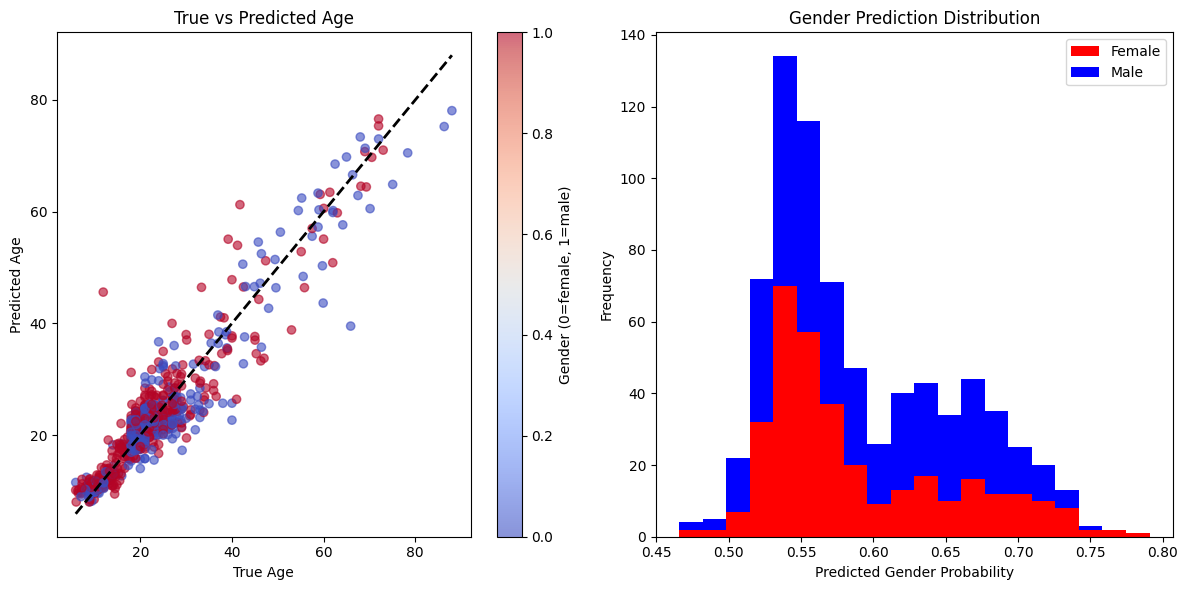

In [9]:

# Compute metrics for overall samples
overall_metrics = compute_metrics(true_ages, pred_ages)
overall_mse_sd = compute_sd((true_ages - pred_ages)**2)
overall_mae_sd = compute_sd(np.abs(true_ages - pred_ages))
overall_rmse_sd = compute_sd(np.sqrt((true_ages - pred_ages)**2))

# Compute metrics for male samples
male_mask = genders == 1
male_metrics = compute_metrics(true_ages[male_mask], pred_ages[male_mask])
male_mse_sd = compute_sd((true_ages[male_mask] - pred_ages[male_mask])**2)
male_mae_sd = compute_sd(np.abs(true_ages[male_mask] - pred_ages[male_mask]))
male_rmse_sd = compute_sd(np.sqrt((true_ages[male_mask] - pred_ages[male_mask])**2))

# Compute metrics for female samples
female_mask = genders == 0 
female_metrics = compute_metrics(true_ages[female_mask], pred_ages[female_mask])
female_mse_sd = compute_sd((true_ages[female_mask] - pred_ages[female_mask])**2)
female_mae_sd = compute_sd(np.abs(true_ages[female_mask] - pred_ages[female_mask]))
female_rmse_sd = compute_sd(np.sqrt((true_ages[female_mask] - pred_ages[female_mask])**2))

# Print the results
print(f'Overall - MSE: {overall_metrics[0]:.2f} (SD: {overall_mse_sd:.2f}), MAE: {overall_metrics[1]:.2f} (SD: {overall_mae_sd:.2f}), RMSE: {overall_metrics[2]:.2f} (SD: {overall_rmse_sd:.2f}), R2: {overall_metrics[3]:.2f}, MAPE: {overall_metrics[4]:.2f}')
print(f'Male - MSE: {male_metrics[0]:.2f} (SD: {male_mse_sd:.2f}), MAE: {male_metrics[1]:.2f} (SD: {male_mae_sd:.2f}), RMSE: {male_metrics[2]:.2f} (SD: {male_rmse_sd:.2f}), R2: {male_metrics[3]:.2f}, MAPE: {male_metrics[4]:.2f}')
print(f'Female - MSE: {female_metrics[0]:.2f} (SD: {female_mse_sd:.2f}), MAE: {female_metrics[1]:.2f} (SD: {female_mae_sd:.2f}), RMSE: {female_metrics[2]:.2f} (SD: {female_rmse_sd:.2f}), R2: {female_metrics[3]:.2f}, MAPE: {female_metrics[4]:.2f}')

# Visualization
def plot_distributions(true_ages, pred_ages, genders, pred_genders):
    plt.figure(figsize=(12, 6))

    # Age prediction distribution
    plt.subplot(1, 2, 1)
    plt.scatter(true_ages, pred_ages, c=genders, cmap='coolwarm', alpha=0.6)
    plt.plot([true_ages.min(), true_ages.max()], [true_ages.min(), true_ages.max()], 'k--', lw=2)
    plt.xlabel('True Age')
    plt.ylabel('Predicted Age')
    plt.title('True vs Predicted Age')
    plt.colorbar(label='Gender (0=female, 1=male)')

    # Gender prediction distribution
    plt.subplot(1, 2, 2)
    plt.hist([pred_genders[genders == 0].flatten(), pred_genders[genders == 1].flatten()], bins=20, stacked=True, color=['r', 'b'], label=['Female', 'Male'])
    plt.xlabel('Predicted Gender Probability')
    plt.ylabel('Frequency')
    plt.title('Gender Prediction Distribution')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_distributions(true_ages, pred_ages, genders, pred_genders)

# Error Analysis
def error_analysis(true_ages, pred_ages):
    errors = true_ages - pred_ages
    plt.figure(figsize=(10, 5))

    plt.hist(errors, bins=30, color='purple', alpha=0.7)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Age Prediction Error Distribution')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.scatter(true_ages, errors, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('True Age')
    plt.ylabel('Prediction Error')
    plt.title('Error Analysis')
    plt.show()


Overall - MSE: 695.50 (SD: 964.39), MAE: 23.11 (SD: 12.76), RMSE: 26.37 (SD: 12.76), R2: -3.27, MAPE: 0.97
Male - MSE: 605.16 (SD: 810.57), MAE: 21.69 (SD: 11.64), RMSE: 24.60 (SD: 11.64), R2: -3.47, MAPE: 0.96
Female - MSE: 806.90 (SD: 1115.33), MAE: 24.85 (SD: 13.81), RMSE: 28.41 (SD: 13.81), R2: -3.23, MAPE: 0.97


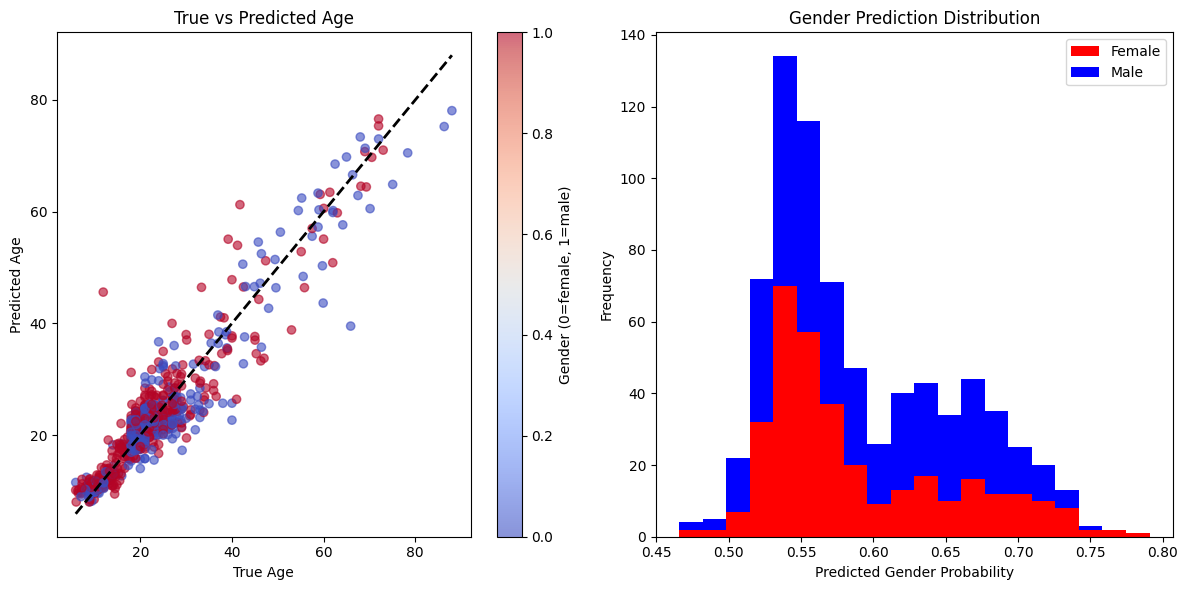

In [8]:

# Compute metrics for overall samples
overall_metrics = compute_metrics(true_ages, aux_ages_block4)
overall_mse_sd = compute_sd((true_ages - aux_ages_block4)**2)
overall_mae_sd = compute_sd(np.abs(true_ages - aux_ages_block4))
overall_rmse_sd = compute_sd(np.sqrt((true_ages - aux_ages_block4)**2))

# Compute metrics for male samples
male_mask = genders == 1
male_metrics = compute_metrics(true_ages[male_mask], aux_ages_block4[male_mask])
male_mse_sd = compute_sd((true_ages[male_mask] - aux_ages_block4[male_mask])**2)
male_mae_sd = compute_sd(np.abs(true_ages[male_mask] - aux_ages_block4[male_mask]))
male_rmse_sd = compute_sd(np.sqrt((true_ages[male_mask] - aux_ages_block4[male_mask])**2))

# Compute metrics for female samples
female_mask = genders == 0 
female_metrics = compute_metrics(true_ages[female_mask], aux_ages_block4[female_mask])
female_mse_sd = compute_sd((true_ages[female_mask] - aux_ages_block4[female_mask])**2)
female_mae_sd = compute_sd(np.abs(true_ages[female_mask] - aux_ages_block4[female_mask]))
female_rmse_sd = compute_sd(np.sqrt((true_ages[female_mask] - aux_ages_block4[female_mask])**2))

# Print the results
print(f'Overall - MSE: {overall_metrics[0]:.2f} (SD: {overall_mse_sd:.2f}), MAE: {overall_metrics[1]:.2f} (SD: {overall_mae_sd:.2f}), RMSE: {overall_metrics[2]:.2f} (SD: {overall_rmse_sd:.2f}), R2: {overall_metrics[3]:.2f}, MAPE: {overall_metrics[4]:.2f}')
print(f'Male - MSE: {male_metrics[0]:.2f} (SD: {male_mse_sd:.2f}), MAE: {male_metrics[1]:.2f} (SD: {male_mae_sd:.2f}), RMSE: {male_metrics[2]:.2f} (SD: {male_rmse_sd:.2f}), R2: {male_metrics[3]:.2f}, MAPE: {male_metrics[4]:.2f}')
print(f'Female - MSE: {female_metrics[0]:.2f} (SD: {female_mse_sd:.2f}), MAE: {female_metrics[1]:.2f} (SD: {female_mae_sd:.2f}), RMSE: {female_metrics[2]:.2f} (SD: {female_rmse_sd:.2f}), R2: {female_metrics[3]:.2f}, MAPE: {female_metrics[4]:.2f}')

# Visualization
def plot_distributions(true_ages, aux_ages_block4, genders, pred_genders):
    plt.figure(figsize=(12, 6))

    # Age prediction distribution
    plt.subplot(1, 2, 1)
    plt.scatter(true_ages, pred_ages, c=genders, cmap='coolwarm', alpha=0.6)
    plt.plot([true_ages.min(), true_ages.max()], [true_ages.min(), true_ages.max()], 'k--', lw=2)
    plt.xlabel('True Age')
    plt.ylabel('Predicted Age')
    plt.title('True vs Predicted Age')
    plt.colorbar(label='Gender (0=female, 1=male)')

    # Gender prediction distribution
    plt.subplot(1, 2, 2)
    plt.hist([pred_genders[genders == 0].flatten(), pred_genders[genders == 1].flatten()], bins=20, stacked=True, color=['r', 'b'], label=['Female', 'Male'])
    plt.xlabel('Predicted Gender Probability')
    plt.ylabel('Frequency')
    plt.title('Gender Prediction Distribution')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_distributions(true_ages, aux_ages_block4, genders, pred_genders)

# Error Analysis
def error_analysis(true_ages, aux_ages_block4):
    errors = true_ages - pred_ages
    plt.figure(figsize=(10, 5))

    plt.hist(errors, bins=30, color='purple', alpha=0.7)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Age Prediction Error Distribution')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.scatter(true_ages, errors, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('True Age')
    plt.ylabel('Prediction Error')
    plt.title('Error Analysis')
    plt.show()
